<a href="https://colab.research.google.com/github/bassamalasadi/Thesis/blob/master/Three%20Tensorflow%20pre-trained%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import the ResNet101 pre-traiend model
from tensorflow.keras.applications import VGG16
#import the Inception pre-traiend model
from tensorflow.keras.applications import InceptionV3
#import the MobileNetV2 pre-traiend model
from tensorflow.keras.applications import MobileNetV2



from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

In [2]:
# The generate_box function will obtain the face coordinates from the annotations fils
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
# The generate_label function will assign label associated with each label and return numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0
# The generate_target function will parse the annotations file and obtain the objects from each XML file
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [3]:
imgs = list(sorted(os.listdir("/content/drive/My Drive/faceMask/images")))
len(imgs)

853

In [4]:
labels = list(sorted(os.listdir("/content/drive/My Drive/faceMask/annotations/")))

In [5]:
# Here we store the number of faces in each image and their coordinates
targets=[]# face coordinates
numobjs=[]# number of faces in each image
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/content/drive/My Drive/faceMask/images/", file_image)
    label_path = os.path.join("/content/drive/My Drive/faceMask/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [6]:
#We continue carrying forward to obtain the faces from the images by using the extract coordinates from the annotation file
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"/content/drive/My Drive/faceMask/images/maksssksksss{}.png".format(i)
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
        locs=(targets[i]['boxes'][j])
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [7]:
# How many faces we have in 853 images
len(face_labels)

4072

In [8]:
# The categories distribution
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 717, 1: 3232, 2: 123}

In [9]:
# Encoding the labels to 2D tensor
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [10]:
# Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [11]:
# Split the data into train sets and test sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [43]:
# Define the learning rate parameter, number of epochs, and the bunch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

Inception3

In [14]:
# Download and define the inceptionV3 pre-trained model
InceptionModel = InceptionV3(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# Construct the model to fit the pre-trained base model
headModel = InceptionModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model1 = Model(inputs=InceptionModel.input, outputs=headModel)

for layer in InceptionModel.layers:
	layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [15]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

I = model1.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10}) 

Epoch 1/20
101/101 [==============================] - 50s 499ms/step - loss: 1.6708 - accuracy: 0.6974 - val_loss: 0.4560 - val_accuracy: 0.8540
Epoch 2/20
101/101 [==============================] - 46s 454ms/step - loss: 1.2589 - accuracy: 0.7944 - val_loss: 0.5050 - val_accuracy: 0.8098
Epoch 3/20
101/101 [==============================] - 46s 451ms/step - loss: 1.1698 - accuracy: 0.8059 - val_loss: 0.4673 - val_accuracy: 0.8209
Epoch 4/20
101/101 [==============================] - 45s 450ms/step - loss: 1.0825 - accuracy: 0.8242 - val_loss: 0.3755 - val_accuracy: 0.8515
Epoch 5/20
101/101 [==============================] - 46s 451ms/step - loss: 1.0397 - accuracy: 0.8301 - val_loss: 0.4658 - val_accuracy: 0.8110
Epoch 6/20
101/101 [==============================] - 45s 449ms/step - loss: 0.9516 - accuracy: 0.8505 - val_loss: 0.3536 - val_accuracy: 0.8564
Epoch 7/20
101/101 [==============================] - 45s 449ms/step - loss: 1.0111 - accuracy: 0.8332 - val_loss: 0.3430 - val_ac

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       143
           1       0.98      0.84      0.90       647
           2       0.36      0.60      0.45        25

    accuracy                           0.86       815
   macro avg       0.66      0.81      0.71       815
weighted avg       0.90      0.86      0.87       815



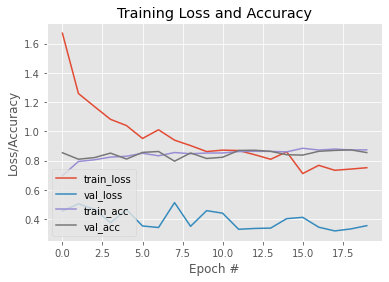

In [17]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model1.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,))

# plot the training loss and accuracy
E1 = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, E1), I.history["loss"], label="train_loss")
plt.plot(np.arange(0, E1), I.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, E1), I.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, E1), I.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [18]:
#save the model 
model1.save('Inception.h5')

In [19]:
#load the saved model
model1 = keras.models.load_model('Inception.h5')

In [20]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
I = model1.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 47s 463ms/step - loss: 0.7330 - accuracy: 0.8800 - val_loss: 0.3353 - val_accuracy: 0.8626
Epoch 2/20
101/101 [==============================] - 45s 445ms/step - loss: 0.7013 - accuracy: 0.8825 - val_loss: 0.2634 - val_accuracy: 0.8871
Epoch 3/20
101/101 [==============================] - 45s 444ms/step - loss: 0.7026 - accuracy: 0.8766 - val_loss: 0.2782 - val_accuracy: 0.8908
Epoch 4/20
101/101 [==============================] - 45s 445ms/step - loss: 0.6981 - accuracy: 0.8868 - val_loss: 0.5865 - val_accuracy: 0.7460
Epoch 5/20
101/101 [==============================] - 45s 442ms/step - loss: 0.7174 - accuracy: 0.8710 - val_loss: 0.3929 - val_accuracy: 0.8442
Epoch 6/20
101/101 [==============================] - 45s 441ms/step - loss: 0.6581 - accuracy: 0.8859 - val_loss: 0.3142 - val_accuracy: 0.8687
Epoch 7/20
101/101 [==============================] - 45s 441ms/step - loss: 0.6

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       143
           1       0.97      0.92      0.94       647
           2       0.50      0.44      0.47        25

    accuracy                           0.91       815
   macro avg       0.74      0.76      0.75       815
weighted avg       0.91      0.91      0.91       815



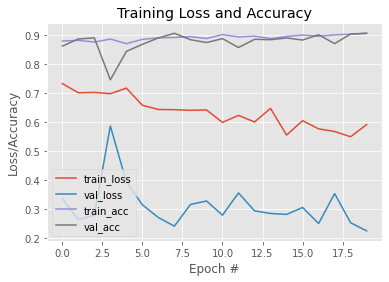

In [21]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model1.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,))

# plot the training loss and accuracy
E1 = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, E1), I.history["loss"], label="train_loss")
plt.plot(np.arange(0, E1), I.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, E1), I.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, E1), I.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [22]:
#save the Inception model
model1.save('face_mask_Inception.h5')

MobileNetV2

In [23]:
# Download and define the ModileNetV2 pre-trained model

MobileNetModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# Construct the model to fit the pre-trained base model
headModel = MobileNetModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model2 = Model(inputs=MobileNetModel.input, outputs=headModel)

for layer in MobileNetModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [24]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

M = model2.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10}) 

Epoch 1/20
101/101 [==============================] - 42s 412ms/step - loss: 1.6940 - accuracy: 0.6809 - val_loss: 0.6639 - val_accuracy: 0.7239
Epoch 2/20
101/101 [==============================] - 40s 399ms/step - loss: 1.2738 - accuracy: 0.7873 - val_loss: 0.5637 - val_accuracy: 0.7534
Epoch 3/20
101/101 [==============================] - 40s 396ms/step - loss: 1.1374 - accuracy: 0.8217 - val_loss: 0.4957 - val_accuracy: 0.7963
Epoch 4/20
101/101 [==============================] - 40s 392ms/step - loss: 1.0920 - accuracy: 0.8295 - val_loss: 0.4398 - val_accuracy: 0.8160
Epoch 5/20
101/101 [==============================] - 39s 390ms/step - loss: 0.9596 - accuracy: 0.8360 - val_loss: 0.4728 - val_accuracy: 0.8184
Epoch 6/20
101/101 [==============================] - 39s 388ms/step - loss: 0.9671 - accuracy: 0.8496 - val_loss: 0.4269 - val_accuracy: 0.8233
Epoch 7/20
101/101 [==============================] - 39s 386ms/step - loss: 0.8706 - accuracy: 0.8571 - val_loss: 0.4432 - val_ac

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.65      0.93      0.76       143
           1       0.97      0.85      0.91       647
           2       0.35      0.56      0.43        25

    accuracy                           0.86       815
   macro avg       0.66      0.78      0.70       815
weighted avg       0.90      0.86      0.87       815



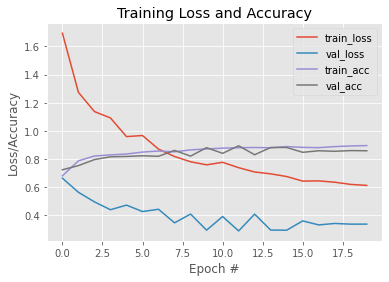

In [25]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model2.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,))

# plot the training loss and accuracy
E2 = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, E2), M.history["loss"], label="train_loss")
plt.plot(np.arange(0, E2), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, E2), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, E2), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

In [26]:
#save the model.
model2.save('MobileNet.h5')

In [27]:
#load the saved model
model2 = keras.models.load_model('MobileNet.h5')

In [28]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
M = model2.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 42s 415ms/step - loss: 0.6118 - accuracy: 0.8998 - val_loss: 0.3794 - val_accuracy: 0.8380
Epoch 2/20
101/101 [==============================] - 41s 406ms/step - loss: 0.5515 - accuracy: 0.8967 - val_loss: 0.2749 - val_accuracy: 0.8908
Epoch 3/20
101/101 [==============================] - 41s 402ms/step - loss: 0.5662 - accuracy: 0.9073 - val_loss: 0.3243 - val_accuracy: 0.8675
Epoch 4/20
101/101 [==============================] - 41s 402ms/step - loss: 0.5716 - accuracy: 0.9045 - val_loss: 0.3367 - val_accuracy: 0.8552
Epoch 5/20
101/101 [==============================] - 41s 401ms/step - loss: 0.5504 - accuracy: 0.9033 - val_loss: 0.2870 - val_accuracy: 0.8798
Epoch 6/20
101/101 [==============================] - 40s 399ms/step - loss: 0.5547 - accuracy: 0.9029 - val_loss: 0.3568 - val_accuracy: 0.8564
Epoch 7/20
101/101 [==============================] - 41s 408ms/step - loss: 0.5

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       143
           1       0.97      0.91      0.94       647
           2       0.41      0.44      0.42        25

    accuracy                           0.90       815
   macro avg       0.70      0.76      0.73       815
weighted avg       0.91      0.90      0.90       815



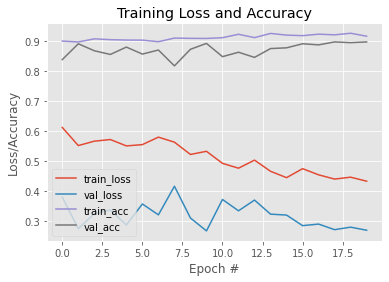

In [29]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model2.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,))

# plot the training loss and accuracy
E2 = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, E2), M.history["loss"], label="train_loss")
plt.plot(np.arange(0, E2), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, E2), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, E2), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [30]:
#save the Mobilenet model
model2.save('face_mask_mobilenet.h5')

VGG16

In [42]:
# Download and define the ResNet101 pre-trained model
ResNetModel = VGG16(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# Construct the model to fit the pre-trained base model
headModel = ResNetModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model3 = Model(inputs=ResNetModel.input, outputs=headModel)

for layer in ResNetModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [44]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model3.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

R = model3.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

Epoch 1/20
101/101 [==============================] - 59s 587ms/step - loss: 2.0235 - accuracy: 0.5805 - val_loss: 0.8679 - val_accuracy: 0.4883
Epoch 2/20
101/101 [==============================] - 51s 507ms/step - loss: 1.8843 - accuracy: 0.5740 - val_loss: 0.8905 - val_accuracy: 0.4834
Epoch 3/20
101/101 [==============================] - 51s 505ms/step - loss: 1.7922 - accuracy: 0.6028 - val_loss: 0.8042 - val_accuracy: 0.5730
Epoch 4/20
101/101 [==============================] - 51s 508ms/step - loss: 1.7139 - accuracy: 0.6636 - val_loss: 0.8895 - val_accuracy: 0.5178
Epoch 5/20
101/101 [==============================] - 51s 508ms/step - loss: 1.6568 - accuracy: 0.6509 - val_loss: 0.7696 - val_accuracy: 0.6135
Epoch 6/20
101/101 [==============================] - 51s 503ms/step - loss: 1.6177 - accuracy: 0.6713 - val_loss: 0.7217 - val_accuracy: 0.6491
Epoch 7/20
101/101 [==============================] - 51s 501ms/step - loss: 1.5821 - accuracy: 0.6825 - val_loss: 0.7768 - val_ac

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.37      0.99      0.54       143
           1       0.96      0.63      0.76       647
           2       0.27      0.12      0.17        25

    accuracy                           0.67       815
   macro avg       0.54      0.58      0.49       815
weighted avg       0.84      0.67      0.70       815



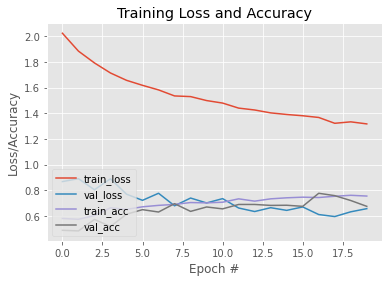

In [45]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model3.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,))

# plot the training loss and accuracy
E3 = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, E3), R.history["loss"], label="train_loss")
plt.plot(np.arange(0, E3), R.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, E3), R.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, E3), R.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [48]:
#save the model.
model3.save('VGG16.h5')

In [49]:
#load the saved model
model3 = keras.models.load_model('VGG16.h5')

In [51]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model3.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
R = model3.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
  class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 51s 510ms/step - loss: 1.2538 - accuracy: 0.7671 - val_loss: 0.5950 - val_accuracy: 0.7411
Epoch 2/20
101/101 [==============================] - 51s 507ms/step - loss: 1.2370 - accuracy: 0.7789 - val_loss: 0.5494 - val_accuracy: 0.7975
Epoch 3/20
101/101 [==============================] - 51s 505ms/step - loss: 1.2441 - accuracy: 0.7798 - val_loss: 0.5868 - val_accuracy: 0.7571
Epoch 4/20
101/101 [==============================] - 51s 505ms/step - loss: 1.2210 - accuracy: 0.7780 - val_loss: 0.5661 - val_accuracy: 0.7546
Epoch 5/20
101/101 [==============================] - 51s 503ms/step - loss: 1.2138 - accuracy: 0.7829 - val_loss: 0.4911 - val_accuracy: 0.8356
Epoch 6/20
101/101 [==============================] - 51s 503ms/step - loss: 1.1946 - accuracy: 0.7922 - val_loss: 0.6678 - val_accuracy: 0.6933
Epoch 7/20
101/101 [==============================] - 51s 504ms/step - loss: 1.1

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       143
           1       0.98      0.80      0.88       647
           2       0.32      0.24      0.27        25

    accuracy                           0.82       815
   macro avg       0.61      0.68      0.62       815
weighted avg       0.88      0.82      0.83       815



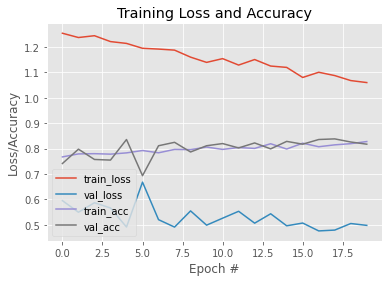

In [52]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model3.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,))

# plot the training loss and accuracy
E3 = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, E3), R.history["loss"], label="train_loss")
plt.plot(np.arange(0, E3), R.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, E3), R.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, E3), R.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [53]:
#save the resnet model.
model3.save('face_mask_VGG16.h5')

visual

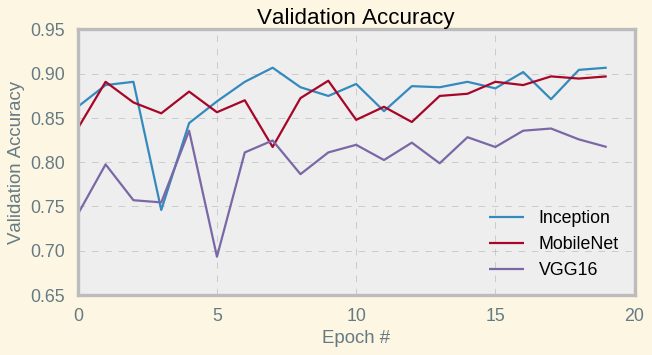

In [127]:
plt.style.use("bmh")
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, E1), I.history["val_accuracy"], label="Inception",linewidth=2, markersize=12)
plt.plot(np.arange(0, E2), M.history["val_accuracy"], label="MobileNet",linewidth=2, markersize=12)
plt.plot(np.arange(0, E3), R.history["val_accuracy"], label="VGG16",linewidth=2, markersize=12)
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

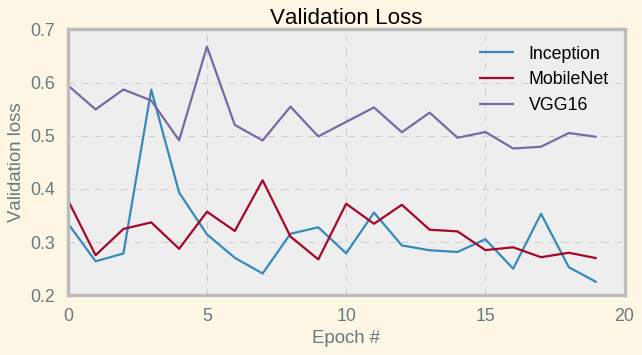

In [128]:
plt.style.use("bmh")
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, E1), I.history["val_loss"], label="Inception")
plt.plot(np.arange(0, E2), M.history["val_loss"], label="MobileNet")
plt.plot(np.arange(0, E3), R.history["val_loss"], label="VGG16")
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Validation loss")
plt.legend(loc="upper right")
plt.show()

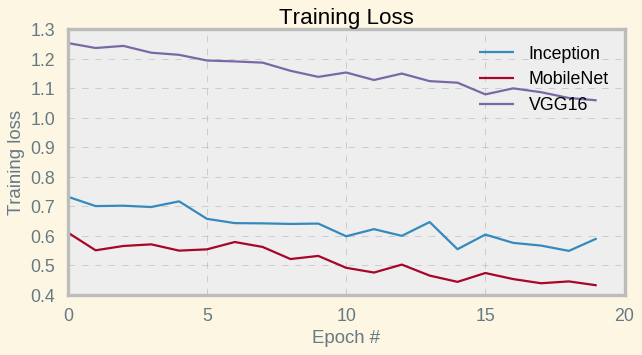

In [131]:
plt.style.use("bmh")
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, E1), I.history["loss"], label="Inception")
plt.plot(np.arange(0, E2), M.history["loss"], label="MobileNet")
plt.plot(np.arange(0, E3), R.history["loss"], label="VGG16")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Training loss")
plt.legend(loc="upper right")
plt.show()

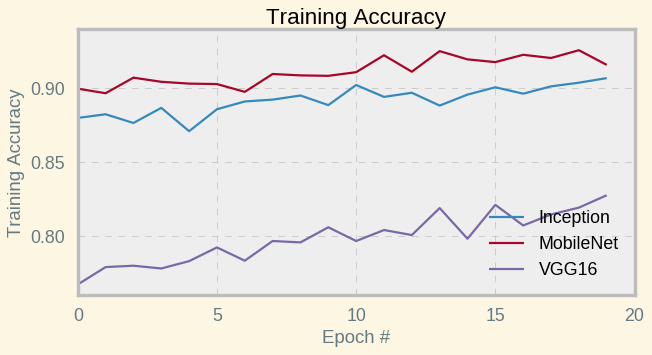

In [132]:
plt.style.use("bmh")
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, E1), I.history["accuracy"], label="Inception")
plt.plot(np.arange(0, E2), M.history["accuracy"], label="MobileNet")
plt.plot(np.arange(0, E3), R.history["accuracy"], label="VGG16")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Training Accuracy")
plt.legend(loc="lower right")
plt.show()